In [295]:
# print(tf.__version__)
print(keras.__version__)


2.13.1


In [ ]:
!lscpu 

In [ ]:
!pip install keras==2.15.0
!pip install tensorflow==2.15.0

In [1]:
seed = 61
import tensorflow as tf
import albumentations as A
import random
import matplotlib.pyplot as plt
import os
import cv2
from keras.callbacks import ModelCheckpoint
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
def reset_seeds():
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)

reset_seeds()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


In [ ]:
!pip install neptune
!pip install neptune-tensorflow-keras

In [ ]:
!pip install keras-flops


In [301]:
import tensorflowjs as tfjs
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

# model = tf.keras.models.load_model('/kaggle/working/modelX2.h5', custom_objects={"f1_score": f1_score })

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'), f1_score])

model = tf.keras.models.load_model('/kaggle/input/resnet18/keras/03-tl-f/1/588f.h5', compile=False)
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

tfjs.converters.save_keras_model(model, '/kaggle/working/model')

import shutil
shutil.make_archive('model', 'zip', '/kaggle/working/model')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(

KeyboardInterrupt



In [ ]:
from keras_flops import get_flops

model = tf.keras.models.load_model('/kaggle/input/fer-2013/keras/mobilenet-tl-finetune/1/modelMB-TL-finetune-6846-225.h5', compile=True)
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

In [ ]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
  graph_info = profile(forward_pass.get_concrete_function().graph, options=ProfileOptionBuilder.float_operation())
  flops = graph_info.total_float_ops
  return flops

# HEIGHT = 48
# WIDTH = 48
# CHANNELS = 3

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val


model = tf.keras.models.load_model('/kaggle/input/fer-2013/keras/mobilenet/1/modelMB-6593-122.h5', custom_objects={"f1_score": f1_score })


optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'), f1_score])

# model.summary()

flops = get_flops(model)
macs = flops / 2
print(f"MACs: {macs:,}")
print(f"FLOPs: {flops:,}")

Found 167 images belonging to 4 classes.
Found 3325 images belonging to 4 classes.


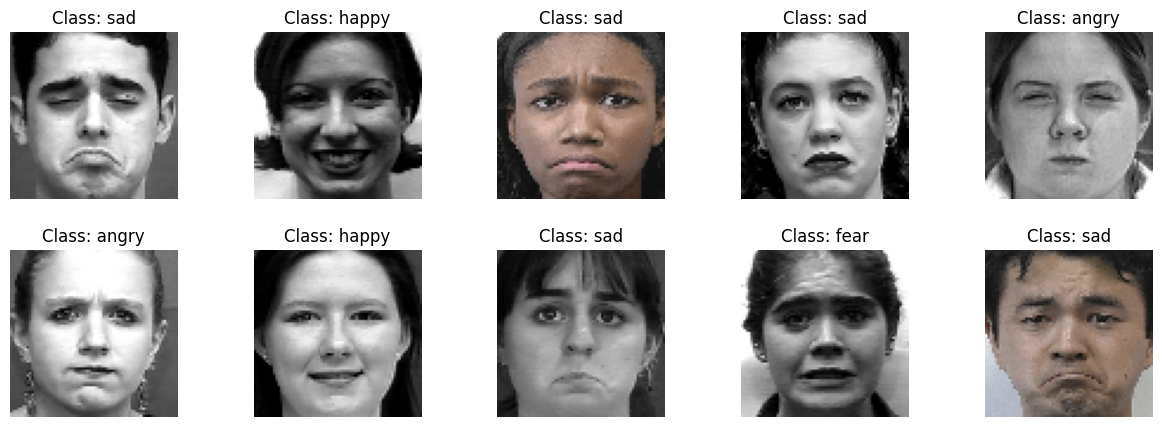

In [40]:
train_dir = '/kaggle/input/fer2013-03n/0.3/train'
# train_dir = '/kaggle/input/fer2013/train'

test_dir = '/kaggle/input/fer-test/Test plus aug'

img_height = 71
img_width = 71
batch_size = 16
classes_num = 5
classes_labels = ["angry", "fear", "happy", "neutral", "sad"]


# augmentation pipeline
# def transform(image):
#     aug = A.Compose([
#         A.Crop(img_height, img_width, p=.5),
#         A.HorizontalFlip(p=.5),
#         # A.RandomBrightnessContrast(p=1, brightness_limit=(-0, 0), contrast_limit=(-0, 0)),
# #         A.GaussianBlur(p=.5, blur_limit=(3, 17), sigma_limit=0)
#     ])
    
#     img = aug(image=image)['image']
#     return img


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=transform,
    rescale=1./255,
#     dtype='float32',
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
)

#  zoom_range=0.3,
#                                    rotation_range=30,
#                                    horizontal_flip=True,
#                                    brightness_range =[0.8,1.2],
#                                    width_shift_range = (-.2, .2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
#     dtype='float32'
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='grayscale', #rgb for transfer learning
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes_labels,
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes_labels,
)

img, label = train_generator.__next__()

# print(img.shape, label.shape)
# i = random.randint(0, (img.shape[0])-1)
# image = img[i]
# lbl = classes_labels[label[i].argmax()]
# plt.imshow(image[:,:,0], cmap='gray')
# plt.title(lbl)
# plt.show()
plt.figure(figsize=(15, 10)) 

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=.3)
    plt.imshow(img[i], cmap='gray')
    plt.title(f"Class: {classes_labels[label[i].argmax()]}")
    plt.axis('off')

plt.savefig("/kaggle/working/img_plot.pdf", format="pdf", bbox_inches="tight")

In [ ]:
from collections import Counter
import seaborn as sns
import matplotlib.patches as mpatches


classes_labels = ["angry", "fear", "happy", "neutral", "sad"]

# counter_train = Counter(train_generator.classes)
counter_test = Counter(test_generator.classes)

# print(counter_train.items())
print(counter_test.items())

# number_train = []
# for label, number in counter_train.items():
#     number_train.append(number)
    

number_test = []
for label, number in counter_test.items():
    number_test.append(number)
    
fontsize=40

plt.figure(figsize=(20, 15)) 
sns.set_theme()
sns.set(font_scale=5)
# sns.barplot(x=number_train, y = classes_labels, color='darkmagenta')
sns.barplot(x=number_test, y = classes_labels, color='darkmagenta')
# top_bar = mpatches.Patch(color='darkmagenta', label='Train')
bottom_bar = mpatches.Patch(color='darkmagenta', label='Test')
# plt.legend(handles=[top_bar, bottom_bar], prop={'size': 20})
plt.legend(handles=[bottom_bar], prop={'size': 30})

plt.xlabel("Number of images", fontsize=fontsize)

plt.savefig("/kaggle/working/class_train_plot.pdf", format="pdf", bbox_inches="tight")


# Calculate Shannon entropy
# unique_labels, counts = np.unique(y, return_counts=True)
# proportions = number_train / np.sum(number_train)
# shannon_entropy = -np.sum(proportions * np.log(proportions))

# print(f'Shannon entropy: {shannon_entropy:.2f}')




In [ ]:
reset_seeds()

import neptune
from getpass import getpass

api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwYjg3YmRiMS0wMWU3LTRhNmEtYmRjZS04OTMzNTg3OWNiMzIifQ=="
project= "maggol/Master-Thesis"
project = neptune.init_project(project=project, api_token=api_token)

run = neptune.init_run(
    project="maggol/Master-Thesis",
    api_token=api_token,
    capture_hardware_metrics=True,
    capture_stderr=True,
    
    capture_stdout=True,
)


from neptune.integrations.tensorflow_keras import NeptuneCallback

neptune_cbk = NeptuneCallback(run=run, base_namespace="metrics")

params = {"epochs": 500, "batch_size": batch_size}
run["parameters"] = params



cosine_lr = tf.keras.optimizers.schedules.CosineDecay(
    1e-5, 1e9, warmup_target=1e-4,
    warmup_steps=1e9
)

learning_rate_decay_start = 40  # 50
learning_rate_decay_every = 3 # 5
learning_rate_decay_rate = 0.5 # 0.9

start_lr = 1e-4

def scheduler(epoch, lr):
    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        lr = start_lr * decay_factor
    else:
        lr = start_lr
    print('learning_rate: %s' % str(lr))
    return lr
    

def reduce_lr(epoch, lr):
    if epoch%5 == 0 and epoch > 1:
        lr = lr * 0.1
    else:
        lr = lr
    print('learning_rate: %s' % str(lr))
    return lr


def reduce_lr_f(epoch, lr):
    if epoch%2 == 0 and epoch > 1 and epoch < 6:
        lr = lr * 0.1
    else:
        lr = lr
    print('learning_rate: %s' % str(lr))
    return lr



def reduce_lr_f_mb(epoch, lr):
    if epoch%5 == 0 and epoch > 1:
        lr = lr * 0.1
    else:
        lr = lr
    print('learning_rate: %s' % str(lr))
    return lr
#tf.math.exp(-0.1)

# tensorflow_addons.optimizers
# cyclical_learning_rate = CyclicalLearningRate(
#  initial_learning_rate=3e-7,
#  maximal_learning_rate=3e-5,
#  step_size=2360,
#  scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
#  scale_mode='cycle')

# optimizer = keras.optimizers.experimental.SGD(learning_rate=1e-3, momentum=0.9, weight_decay=1e-4, nesterov=True)
# optimizer = Adam(learning_rate=start_lr)
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
callback = tf.keras.callbacks.LearningRateScheduler(reduce_lr_f_mb)

In [ ]:
from sklearn.utils import class_weight

print(np.unique(train_generator.classes), train_generator.classes)

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(train_generator.classes), 
                                                 y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

In [ ]:
# base_model = tf.keras.applications.MobileNetV2(weights=None, input_shape=(img_height, img_width, 1), classes=classes_num, include_top=False)
base_model = tf.keras.applications.Xception(weights=None, input_shape=(img_height, img_width, 1), classes=classes_num, include_top=False)
# base_model = tf.keras.applications.resnet50.ResNet50(weights=None, input_shape=(img_height, img_width, 3), classes=classes_num, include_top=False)
# model = tf.keras.models.load_model('/kaggle/working/modelX3.h5')
# ResNet34, preprocess_input = Classifiers.get('resnet34')
# model = ResNet34((224,224,1), weights=None, classes=5)
# tf.keras.backend.clear_session()

dropout_rate = 0.3
x = base_model.output
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(classes_num, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)


# model.summary()

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

# model = tf.keras.models.load_model('/kaggle/working/modelX2.h5', custom_objects={"f1_score": f1_score })

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'), f1_score])

num_train_imgs = 25102
# for root, dirs, files in os.walk(train_dir):
#     num_train_imgs += len(files)

num_test_imgs = 6236
# for root, dirs, files in os.walk(validation_dir):
#     num_validation_imgs += len(files)

epochs = params["epochs"]
# checkpoint = ModelCheckpoint('/kaggle/working/model-{epoch:03d}.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/modelX-finetune.h5',
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only = True,
                            verbose=1)


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 50, verbose = 1, restore_best_weights=True)
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 10,verbose = 1,factor = 0.1, min_lr = 1e-20)

history = model.fit(
                    train_generator,
                    steps_per_epoch=num_train_imgs//batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=num_test_imgs//batch_size,
                    callbacks=[checkpoint, neptune_cbk, lrd],
                    class_weight=train_class_weights
                    )

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
run.stop()
# model.save('/kaggle/working/modelX-minloss.h5')
8989
89



In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

In [ ]:
# TRANSFER LEARNING

# import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
# from keras.applications.resnet50 import preprocess_input
# from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.xception import preprocess_input


# from classification_models.keras import Classifiers

# ResNet18, preprocess_input = Classifiers.get('resnet18')
# base_model = ResNet18((img_height,img_width,3), weights='imagenet', include_top=False)

base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# # # # base_model.trainable = False
for layer in base_model.layers[:-38]:
    layer.trainable = False
    

dropout_rate = 0.5

i = tf.keras.layers.Input([img_height, img_width, 3])
x = tf.cast(i, tf.float32)
x = preprocess_input(x)
core = base_model
x = core(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.2))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.2), kernel_initializer='he_uniform')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.2), kernel_initializer='he_uniform')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.2), kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(classes_num, activation='softmax')(x)


model = tf.keras.Model(inputs=[i], outputs=[x])
    
# model.summary()


def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val


model = tf.keras.models.load_model('/kaggle/working/modelX-TL.h5', custom_objects={"f1_score": f1_score })
for layer in model.layers:
    layer.trainable=True
    
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'), f1_score])

num_train_imgs = 25102


num_test_imgs = 6236


epochs = params["epochs"]
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/modelX-TL-finetune.h5',
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only = True,
                            verbose=1)


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 50, verbose = 1, restore_best_weights=True)
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 10,verbose = 1,factor = 0.1, min_lr = 1e-20)

history = model.fit(
                    train_generator,
                    steps_per_epoch=num_train_imgs//batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=num_test_imgs//batch_size,
                    callbacks=[checkpoint, neptune_cbk, callback],
                    class_weight=train_class_weights
                    )

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




In [ ]:
run.stop()


89
89


In [7]:
test_dir = '/kaggle/input/fer-test/Test plus aug'

img_height = 48
img_width = 48
# bigger batches for testing
batch_size = 16
classes_num = 5
classes_labels = ["angry", "fear", "happy", "neutral", "sad"]


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255
)

#grayscale
test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes_labels,
    shuffle=False
)
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
loaded_model = tf.keras.models.load_model('/kaggle/input/mobilenetv2/keras/0/1/272.h5', compile=False)

loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# scores = loaded_model.evaluate(test_generator)
# print("%s%s: %.2f%%" % ("evaluate ", ['accuracy'], scores[1]*100))




Found 4193 images belonging to 5 classes.


In [8]:
from sklearn.metrics import classification_report
classes_labels = ["angry", "fear", "happy", "neutral", "sad"]
y_test = test_generator.classes
y_pred = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test,y_pred,target_names = classes_labels, digits=4))

263/263 [==============================] - 12s 41ms/step
              precision    recall  f1-score   support

       angry     0.6618    0.4813    0.5573       854
        fear     0.6340    0.4174    0.5034       714
       happy     0.9112    0.9031    0.9071      1022
     neutral     0.5253    0.7304    0.6111       868
         sad     0.4025    0.4830    0.4391       735

    accuracy                         0.6251      4193
   macro avg     0.6270    0.6030    0.6036      4193
weighted avg     0.6441    0.6251    0.6238      4193



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(15, 15)) 
sns.heatmap(cm, annot=True, fmt=".1f", linewidth=.5,
           cmap=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True),
           xticklabels=classes_labels,  yticklabels=classes_labels)
plt.savefig("/kaggle/working/matrix.pdf", format="pdf", bbox_inches="tight")